# Optimise pruning parameters for NGF neurons

This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 150 micrometers.

In [1]:
import os
import numpy as np

n_neurons = 150

pop_size = 15
# epochs = 10

pre_type = "ChIN"  
post_type = "NGF"
con_type = "GABA"

avg_num_synapses_per_pair = 3  # Expected mean, error weight

# param_names = ["f1", "softMax", "mu2", "a3"]
param_names = ["f1", "mu2", "a3"]

distance_dependent_pruning = False

extra_pruning_parameters = { }
        
dd_str = "_distdep" if distance_dependent_pruning else ""
par_str = "_".join(param_names) + dd_str
network_path = os.path.join("networks", f"{pre_type}_to_{post_type}_{par_str}")
        
all_experimental_data = {}

### New data ###

all_experimental_data["NGF", "dSPN"] = [(0, 100e-6, 25/29.0)]
all_experimental_data["NGF", "iSPN"] = [(0, 100e-6, 25/29.0)]
all_experimental_data["NGF", "ChIN"] = [(0, 100e-6, 3/14.0)] # Guessed distance range
all_experimental_data["FS", "NGF"] = [(0, 150e-6, 9/9.0)] # !!! THIS CANT BE RIGHT?!! optogenetic stim all FS
all_experimental_data["ChIN", "NGF"] = [(0, 100e-6, 8/14.0)] # Guessed distance range

### Old data ###

all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

all_experimental_data["FS", "FS"] = [(0, 250e-6, 7/12.0)]
all_experimental_data["FS", "iSPN"] = [(0, 100e-6, 6/9.0), (0, 150e-6, 21/54.0), (0, 250e-6, 27/77.0)]
all_experimental_data["FS", "dSPN"] = [(0, 100e-6, 8/9.0), (0, 150e-6, 29/48.0), (0, 250e-6, 48/90.0)]
all_experimental_data["FS", "LTS"] = [(0, 250e-6, 2/12.0)]

all_experimental_data["LTS", "dSPN"] = [(0, 250e-6, 2/60.0)]
all_experimental_data["LTS", "iSPN"] = [(0, 250e-6, 2/60.0)]

all_experimental_data["ChIN", "dSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "iSPN"] = [(0, 250e-6, 0.05)]

###    ###

experimental_data = all_experimental_data[pre_type, post_type]

cube_side = np.max([x[1] for x in experimental_data])

axon_cloud = dict()
LTS_density_str = ("12*3000*1e12*( 0.25*exp(-(((x-200e-6)/100e-6)**2 "
                           "+ ((y-0)/50e-6)**2 + ((z-0)/30e-6)**2)) "
                           "+ 1*exp(-(((x-300e-6)/300e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/10e-6)**2)) "
                           "+ 1*exp(-(((x-700e-6)/100e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/15e-6)**2)) )")

axon_cloud["LTS"] = ("xyz", LTS_density_str, [-200e-6, 900e-6, -100e-6, 100e-6, -30e-6, 30e-6])
axon_cloud["CHIN"] = ("r", "5000*1e12/3*exp(-r/120e-6)", 350e-6)

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], cube_side)

from snudda.init import SnuddaInit
# snudda_data = "../../../../BasalGangliaData/data/"
snudda_data = "/home/hjorth/TEMP/KadriBGD/BasalGangliaData/data"
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data=snudda_data)

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type in axon_cloud:
    pre_ac = axon_cloud[pre_type]
else:
    pre_ac = None
    
if post_type in axon_cloud:
    post_ac = axon_cloud[post_type]
else:
    post_ac = None

if pre_type == post_type:
    
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum",pre_type.lower()))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", pre_type.lower()))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=post_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", post_type.lower()))
    
# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     connection_type=con_type,
                     dist_pruning=None,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: ChIN from dir /home/hjorth/TEMP/KadriBGD/BasalGangliaData/data/neurons/striatum/chin
Adding neurons: NGF from dir /home/hjorth/TEMP/KadriBGD/BasalGangliaData/data/neurons/striatum/ngf
Writing networks/ChIN_to_NGF_f1_mu2_a3/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=/home/hjorth/TEMP/KadriBGD/BasalGangliaData/data from networks/ChIN_to_NGF_f1_mu2_a3/network-config.json
Generating 1104 points for networks/ChIN_to_NGF_f1_mu2_a3/cube-mesh.obj
n_points = 1050, previous close_pairs = 2078
n_points = 999, previous close_pairs = 1694
n_points = 951, previous close_pairs = 1405
n_points = 905, previous close_pairs = 1162
n_points = 862, previous close_pairs = 959
n_points = 821, previous close_pairs = 795
n_points = 783, previous close_pairs = 660
n_points = 748, previous close_pairs = 556
n_points = 716, previous close_pairs = 456
n_points = 687, previous close_pairs = 382
n_points = 661, previous close_pairs = 326
n_points = 637, previous close_pairs = 275
n_points = 616, previous close_pairs = 231
n_points = 598, previous close_pairs = 189
n_points = 595, previous close_pairs = 157
n_points = 444, previous close_pairs = 151
Filtering 444 points..
Filtering, keeping inside points: 218 / 444


Reading SNUDDA_DATA=/home/hjorth/TEMP/KadriBGD/BasalGangliaData/data from networks/ChIN_to_NGF_f1_mu2_a3/network-config.json


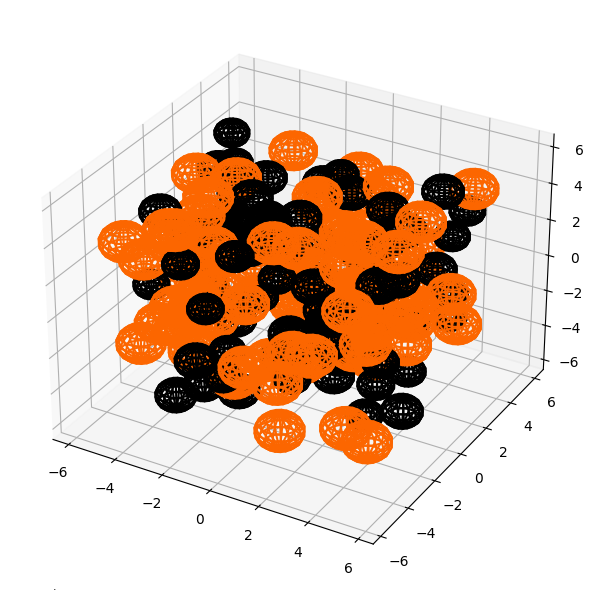

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/TEMP/KadriBGD/BasalGangliaData/data from networks/ChIN_to_NGF_f1_mu2_a3/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 21/80 (150 neurons)
Processing hyper voxel : 17/80 (146 neurons)
Processing hyper voxel : 37/80 (97 neurons)
Processing hyper voxel : 20/80 (93 neurons)
Processing hyper voxel : 22/80 (87 neurons)
Processing hyper voxel : 5/80 (85 neurons)
Processing hyper voxel : 16/80 (64 neurons)
Processing hyper voxel : 33/80 (59 neurons)
Processing hyper voxel : 18/80 (54 neurons)
Processing hyper voxel : 1/80 (51 neurons)
Processing hyper voxel : 25/80 (25 neurons)
Processing hyper voxel : 36/80 (24 neurons)
Processing hyper voxel : 38/80 (23 neurons)
Processing hyper voxel : 6/80 (21 neurons)
Processing hyper voxel : 4/80 (15 neurons)
Processing hyper voxel : 41/80 (10 neurons)
Processing hyper voxel : 32/80 (9 neurons)
Processing hyper voxel : 0/80 (9 neurons)
Processing hyper voxel : 2/80 

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 4052 out of total 4052 synapses


In [8]:
op.prune.connectivity_distributions

{(2,
  1,
  10): (OrderedDict([('f1', 1.0),
               ('softMax', None),
               ('mu2', None),
               ('a3', None),
               ('distPruning', None),
               ('clusterPruning', False)]), None)}

In [9]:
op.prune.type_id_lookup

{'NGF': 1, 'ChIN': 2}

In [10]:
op.prune.hist_file["meta/connectivityDistributions"][()]

b'{"ChIN$$NGF": {"GABA": {"conductance": [2.4e-10, 1e-10], "channelParameters": {"modFile": "tmGabaA"}, "clusterSize": 1, "clusterSpread": null, "pruning": {"f1": null, "softMax": null, "mu2": null, "a3": null, "distPruning": null, "clusterPruning": false}, "channelModelID": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=1000, pop_size=pop_size, tol=0.00001, 
                  param_names=param_names, param_bounds="default")

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Worker iter: 100, fitness 43.90404295061623
Worker iter: 100, fitness 43.864275466864484
Worker iter: 100, fitness 43.85492711219875
Worker iter: 100, fitness 43.87309185062205
Worker iter: 100, fitness 43.83651639717059
Worker iter: 100, fitness 43.855419781052916
Worker iter: 100, fitness 43.82080809634978
Worker iter: 100, fitness 43.834083879724176
Worker iter: 200, fitness 43.63301243494969
Worker iter: 200, fitness 43.60840237359395
Worker iter: 200, fitness 43.61432654421006
Worker iter: 200, fitness 43.61432654421006
Worker iter: 200, fitness 43.60840237359395
Worker iter: 200, fitness 43.63301243494969
Worker iter: 200, fitness 43.60840237359395
Worker iter: 200, fitness 43.61432654421006
Worker iter: 300, fitness 43.59951611766977
Worker iter: 300, fitness 43.59951611766977
Worker iter: 300, fitness 43.595639266686945
Worker iter: 300, fitness 43.595639266686945
Worker iter: 300, fitness 43.59951611766977
Worker iter: 300, fitness 43.59951611766977
Worker iter: 300, fitness 4

In [12]:
op.export_json(f"network-config-opt-NGF.json", res=res, append=True)

# Best parameter set

In [13]:
param_str = ""
for p_name, p_val in zip(param_names, res.x):
    param_str += f"{p_name} = {p_val:.4f}, "
    
if "distPruning" in extra_pruning_parameters:
   param_str += f" ({extra_pruning_parameters['distPruning']})"                                                  
                                                 
print(param_str)

f1 = 0.9208, mu2 = 0.3393, a3 = 1.0000, 


In [14]:
res

 message: Optimization terminated successfully.
 success: True
     fun: 43.58083760890127
       x: [ 9.208e-01  3.393e-01  1.000e+00]
     nit: 85
    nfev: 3874

In [15]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
# list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
# network_file = max(list_of_files, key=os.path.getctime)

network_file = os.path.join(network_path, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Creating figures directory networks/ChIN_to_NGF_f1_mu2_a3/figures
Number of neurons: 150
Synapse row 0 - 0.0 % time: 0.0008332559991686139 seconds
Created connection matrix 0.00513524499911 seconds
Created gap junction connection matrix 7.929200000944547e-05 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 3741, at 0
Created distance histogram (optimised) in 0.0033860250005091075 seconds
Saving cache to networks/ChIN_to_NGF_f1_mu2_a3/network-synapses.hdf5-cache


Plotting connection probability ChIN to NGF (synapses)
Centering in None : Keeping 75/75
Counting connections
Requested: 10000000.0 calculated [5625.]
P(d<0.0001) = 0.3035617429036341


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1438: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


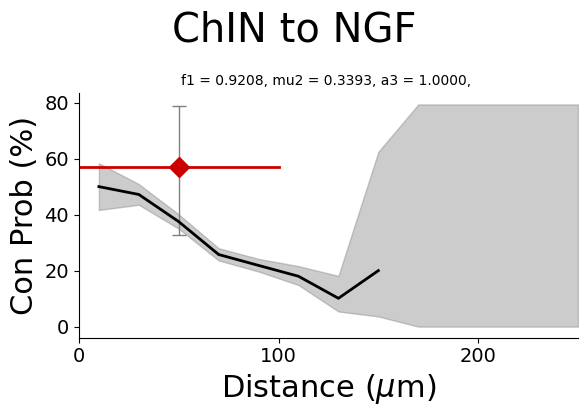

Wrote networks/ChIN_to_NGF_f1_mu2_a3/figures/Network-distance-dependent-connection-probability-ChIN-to-NGF-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 75/75
Calculating max synapses
Calculating mean synapses
Plotting 1689 connections


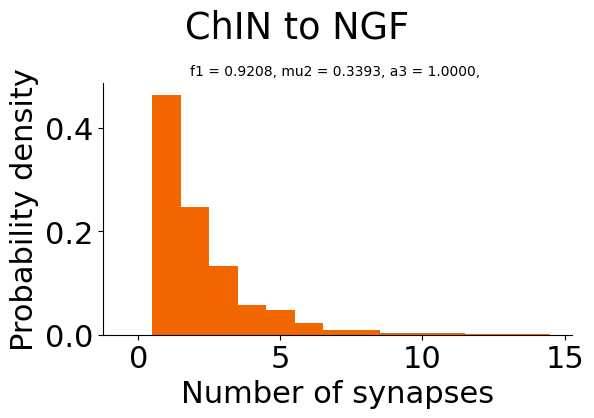

Wrote networks/ChIN_to_NGF_f1_mu2_a3/figures/Network-number-of-synapses-from-ChIN-to-NGF-per-cell.png


In [17]:
if pre_type == "dSPN" and post_type == "iSPN":
    sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "iSPN", sub_title=param_str)
elif pre_type == "dSPN" and post_type == "dSPN":
    sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "dSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "iSPN":
    sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "iSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "dSPN":
    sa.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "dSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "FS":
    sa.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "FS", sub_title=param_str)
elif pre_type == "FS" and post_type == "iSPN":
    sa.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "iSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "dSPN":
    sa.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "dSPN", sub_title=param_str)
    
elif pre_type == "FS" and post_type == "LTS":
    sa.plot_connection_probability("FS", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "LTS", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "dSPN":
    sa.plot_connection_probability("LTS", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "dSPN", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "iSPN":
    sa.plot_connection_probability("LTS", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "iSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "dSPN":
    sa.plot_connection_probability("ChIN", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "dSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "iSPN":
    sa.plot_connection_probability("ChIN", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "iSPN", sub_title=param_str)

# Missing pairwise experimental data...
    
elif pre_type == 'ChIN' and post_type == "FS":
    sa.plot_connection_probability("ChIN", "FS", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "FS", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "LTS":
    sa.plot_connection_probability("ChIN", "LTS", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "LTS", sub_title=param_str)

elif pre_type == 'LTS' and post_type == "ChIN":
    sa.plot_connection_probability("LTS", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "ChIN", sub_title=param_str)

    
elif pre_type == 'dSPN' and post_type == "ChIN":
    sa.plot_connection_probability("dSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "ChIN", sub_title=param_str)
elif pre_type == 'iSPN' and post_type == "ChIN":
    sa.plot_connection_probability("iSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "ChIN", sub_title=param_str)

# New data
elif pre_type == 'NGF' and post_type == "dSPN":
    sa.plot_connection_probability("NGF", "dSPN", dist_3d=True, exp_max_dist=[100e-6], exp_data_detailed=[(25, 29)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "dSPN", sub_title=param_str)

elif pre_type == 'NGF' and post_type == "iSPN":
    sa.plot_connection_probability("NGF", "iSPN", dist_3d=True, exp_max_dist=[100e-6], exp_data_detailed=[(25, 29)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "iSPN", sub_title=param_str)

elif pre_type == 'NGF' and post_type == "ChIN":
    sa.plot_connection_probability("NGF", "ChIN", dist_3d=True, exp_max_dist=[100e-6], exp_data_detailed=[(3, 14)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "ChIN", sub_title=param_str)

elif pre_type == 'FS' and post_type == "NGF":
    sa.plot_connection_probability("FS", "NGF", dist_3d=True, exp_max_dist=[150e-6], exp_data_detailed=[(9, 9)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "NGF", sub_title=param_str)

elif pre_type == 'ChIN' and post_type == "NGF":
    sa.plot_connection_probability("ChIN", "NGF", dist_3d=True, exp_max_dist=[100e-6], exp_data_detailed=[(8, 14)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "NGF", sub_title=param_str)
